In [1]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

%matplotlib inline

The purpose of this notebook is to model the motion of a flapping fish in python but in a way that can be directly translated to an Ansys Fluent UDF function

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
#dx = (0.5*(1-np.cos(beta)))
# uniform spacing
dx = np.linspace(0.0, chord, 100)
x, y = ar.naca4(dx, 0.12, chord, 0.0, 0.30, True)

(-0.1, 0.1)

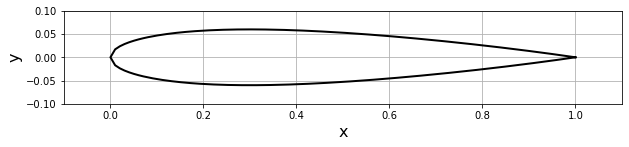

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

Output airfoil to a file for geometry import

In [4]:
output_file = './naca0012.csv'
BL = 0.2553

if os.path.exists(output_file):
    os.remove(output_file)

# for spaceclaim coordinates
#output_data = np.array(list(zip(np.zeros(len(x)),x*BL*1000, y*BL*1000)))
#np.savetxt(output_file, output_data, delimiter=',', fmt='%f', header='Polyline=True' )

# for design modeler coordinates
#output_data = np.array(list(zip(np.ones(len(x)),np.arange(1, len(x), 1), x*BL*1000,y*BL*1000,np.zeros(len(x)))))
#np.savetxt(output_file, output_data, delimiter=',', fmt='%f', header='Group, Points, X-coord, Y-coord, Z-coord')

Motion as determined by Zhu et al.

- A_h = 0.05 BL
- A_t = 0.15 BL
- x_pivot = 0.3 BL
- frequency = 2.477 Hz
- velocity = 0.3478 ms^-1
- Strouhal = 1.136925

In [5]:
BL = 0.2553
Lp = BL-0.0893
phi = np.radians(16)
frequency = 2.477
w = 2*np.pi*frequency
lam = 3.0
k = 2*np.pi/lam
St = 1.136925
U_fish = 0.3478
x_pivot = 0.4*BL
A_t = 0.07*BL
A_p = 0.00*BL
A_h = 0.05*BL
print(w, k)

time = np.linspace(0, 1/frequency, 9)
x_coord = np.linspace(0, BL, 100)

# solving for the coefficients
X = np.array([[1, 0, 0],[1, x_pivot, x_pivot**2], [1, BL, BL**2]])
A = np.array([[A_h], [A_p], [A_t]])
C = np.linalg.solve(X, A)
print(C)

15.563450005883833 2.0943951023931953
[[ 0.012765  ]
 [-0.22166667]
 [ 0.94659877]]


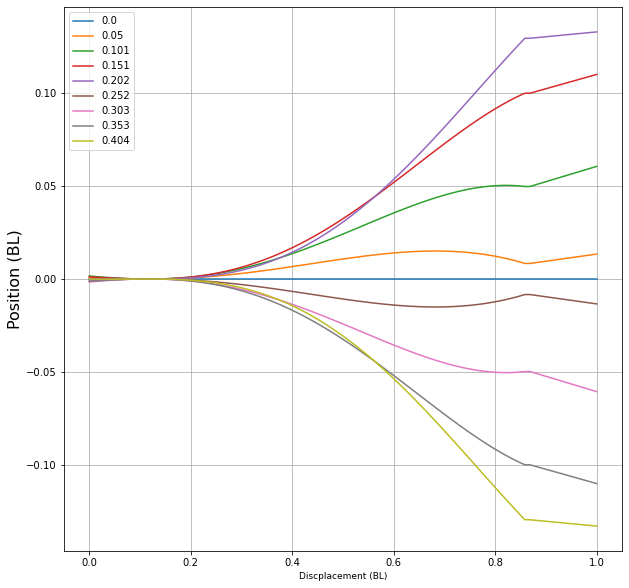

In [19]:
def h_wrt_time(dx, t, BL, w, k, c):
    xbar = dx/BL
    indexes = np.where(xbar <= 0.86)[0]
    mask = np.ones(dx.size, dtype=bool)
    mask[indexes]=False
    
    x_body = xbar[indexes]
    x_tail = xbar[mask]
    A = (c[0]+c[1]*x_body + c[2]*x_body**2)*BL/2
    
    if(np.sin(w*t) >= 0):
        Y1 = np.multiply(A, np.sin(w*t - k*x_body)) - np.multiply(A, np.sin(-k*x_body))
    else:
        Y1 = np.multiply(A, np.sin(w*t - k*x_body)) + np.multiply(A, np.sin(-k*x_body)) 
    
    theta_max = np.radians(18.76)
    phi = np.radians(85.0)
    theta = theta_max*np.sin(w*t - k*x_body[-1] + phi)
    
    Y2 = x_tail*np.tan(theta)*BL
    Y2 = Y2-Y2[0]+Y1[-1]
    
    return np.append(Y1, Y2)

# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('Discplacement (BL)', fontsize=9)
plt.ylabel('Position (BL)', fontsize=16)
for idx, t in enumerate(time):
    if(t == 0):
        plt.plot(x_coord/BL, np.zeros(len(x_coord)), label=np.round(t, 3))
    else:
        plt.plot(x_coord/BL, h_wrt_time(x_coord, t, BL, w, k, C), label=np.round(t, 3))
    
plt.legend()
    #plt.axis('scaled')

In [ ]:
def updated_node_pos(x_coord, time, WL, k, C):
    y_coord = h_wrt_time(x_coord, time, WL, k, C)
    z_coord = np.zeros(len(x_coord))
    


width = 30
nrows = int(np.ceil(len(time)/2))
fig, axs = plt.subplots(nrows, 2, figsize=(width/2, width), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5)

axs = axs.ravel()

y_original = y

for idx, t in enumerate(time):
    if(t == 0):
        y_new = y_original
        axs[idx].plot(x, y_new)
        axs[idx].plot(x_coord/BL, np.zeros(len(x_coord)))
        axs[idx].set_title('Timestep: ' + str(np.round(t,3)))
        axs[idx].set_ylabel('h(x,t) displacement')
        axs[idx].set_xlabel('Position (BL)')
        axs[idx].set_aspect('equal')
        axs[idx].set_xlim(-0.1, 1.1)
        axs[idx].set_ylim(-0.2, 0.2)
    else:
        h_prev = h_wrt_time(x_coord, time[idx-1], BL, w, k, C)
        y_prev = y_original + np.append(np.flipud(h_prev), h_prev[1::])
        h_new = h_wrt_time(x_coord, t, BL, w, k, C)
        h_diff = h_new - h_prev
        y_new = y_prev + np.append(np.flipud(h_diff), h_diff[1::])
        axs[idx].plot(x, y_new)
        axs[idx].plot(x_coord/BL, h_new)
        axs[idx].set_title('Timestep: ' + str(np.round(t,3)))
        axs[idx].set_ylabel('h(x,t) displacement')
        axs[idx].set_xlabel('Position (BL)')
        axs[idx].set_aspect('equal')
        axs[idx].set_xlim(-0.1, 1.1)
        axs[idx].set_ylim(-0.2, 0.2)

In [ ]:
def changyanzuo(dx, t, BL, k, w):
    xbar = dx/BL
    return (BL*(0.351*np.sin(xbar-1.796)+0.359)*
           np.sin(w*t-k*dx))

# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('Discplacement (BL)', fontsize=9)
plt.ylabel('Position (BL)', fontsize=16)
for t in time:
    if(t == 0):
        plt.plot(x_coord/BL, np.zeros(len(x_coord))/BL, label=np.round(t, 3))
    else:
        plt.plot(x_coord/BL, changyanzuo(x_coord, t, BL, k, w)/BL, label=np.round(t, 3))
    
plt.legend()